In [1]:
import sw_functions as sw
import numpy as np
import jax #https://jax.readthedocs.io/en/latest/notebooks/quickstart.html
import jax.numpy as jnp
import os
from matplotlib import pyplot as plt

In [2]:
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/n/helmod/apps/centos7/Core/cuda/10.1.243-fasrc01/"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

## Pairwise alignment with Smoothed Smith-Waterman

(sim_matrix)_{ij} measures the similarity between seq 1 position i and seq 2 position j \
e.g. blosum score between residue at seq 1 position i and residue at seq 2 position j\
e.g. dot product of vector representation of seq 1 position i and seq 2 position j

In [4]:
seq_1_len = 100
seq_2_len = 150
sim_matrix = jnp.array(np.random.random((seq_1_len, seq_2_len)))

There are two Smith-Waterman functions in sw_functions
1. sw (with a gap penalty)
2. sw_affine (with a seperate "open" and "extend" gap penalties) 
3. nw (needleman-wunsch: standard gap penalty and global alignment)

Note sw_affine is about three times as memory intensive as sw, so only use it if you need an affine gap 

All functions return a function, which you can then apply to your data

In [5]:
my_sw_func = jax.jit(sw.sw(batch=False))
my_affine_sw_func = jax.jit(sw.sw_affine(batch=False))
my_nw_func = jax.jit(sw.nw(batch=False))

The function constructs a probability distribution over alignments. 

The value of aln_{ij} is the probability that seq 1 position i is aligned to seq 2 position j 

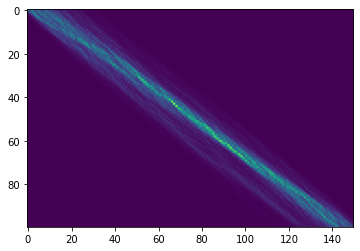

In [6]:
aln = my_sw_func(sim_matrix, (seq_1_len, seq_2_len), gap=-1)
plt.imshow(aln);

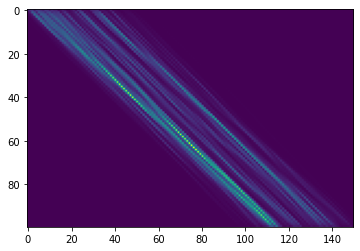

In [7]:
aln = my_affine_sw_func(sim_matrix, (seq_1_len, seq_2_len), gap=-1, open= -3)
plt.imshow(aln);

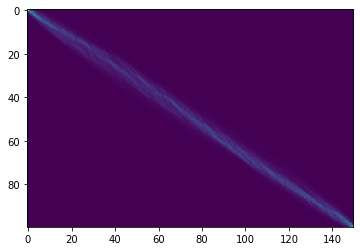

In [8]:
aln = my_nw_func(sim_matrix, (seq_1_len, seq_2_len), gap=-1)
plt.imshow(aln);

Since there are seperate open and extend gap penalty in the second plot, alignments with fewer segements of gaps are favored.

In the third plot, paths begin and end in the corners since it is global alignment.

We don't see a clear alignments because this is random data. 

## Now with batches

If you want to compute pairwise alignment for many pairs at once, you can iterate over all pairs and apply the function. It is much faster to instead use batches and enjoy the time savings of vectorization.

The input will have the form batch size x max length 1 x max length 2, where input[i,:,:] is the sim_matrix of the i^th pair.

The sequences must be padded so that all the "seq 1's" have a fixed length and all the "seq 2's" have a fixed length. The length input parameter tells the algorithm where the sequences end.

Here lens will have the form batch size x 2 where lens_i1 and lens_i2 are the lengths of seq 1 and seq 2 of the ith pair

Before moving on to batches, here is how the length parameter works with a single pair.

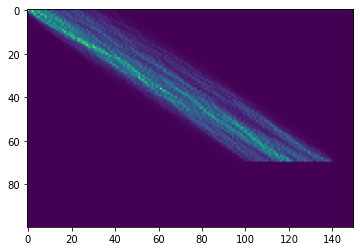

In [9]:
aln = my_affine_sw_func(sim_matrix, (seq_1_len -30, seq_2_len -10), gap=-1)
plt.imshow(aln);

Data for batches

In [10]:
seq_1_max_len = 100
seq_2_max_len = 120
num_pairs = 200
sim_matrices = jnp.array(np.random.random((num_pairs,seq_1_max_len, seq_2_max_len)))
lens = jnp.array([jnp.array([np.random.choice([80,90,100]),np.random.choice([95,105,120])]) for _ in range(num_pairs)])

Batch functions

In [11]:
my_sw_func_batch = jax.jit(sw.sw(batch=True))
my_affine_sw_func_batch = jax.jit(sw.sw_affine(batch=True))
my_nw_func_batch = jax.jit(sw.nw(batch=True))

Things to know about vmap (which vectorizes our code):
1. You have to put in all the input parameters in order-- it won't recognize default settings. 
2. You cannot specify an input parameter by name e.g. "gap = -1"
3. The first time you run it is slower than all subsequent times

(Here the fourth parameter is temperature which is set to 1.0 by default)

In [12]:
# first run is slow
%time alns = my_sw_func_batch(sim_matrices, lens, -1.0, 1.0)

CPU times: user 2.81 s, sys: 357 ms, total: 3.17 s
Wall time: 1.51 s


In [13]:
# all subsequent runs are fast (even if I change the inputs)
%time alns = my_sw_func_batch(sim_matrices, lens, -1.0, 1.0)

CPU times: user 27.8 ms, sys: 5.28 ms, total: 33.1 ms
Wall time: 30 ms


In [14]:
%%time
# for loops are really slow
for i in range(num_pairs):
    aln = my_sw_func(sim_matrices[i,...], lens[i,...], gap=-1)

CPU times: user 5.19 s, sys: 796 ms, total: 5.98 s
Wall time: 4.64 s


Let's check that our results are the same by looking an example

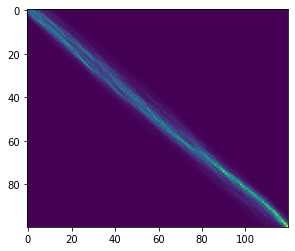

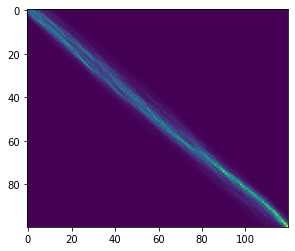

In [15]:
i=10
aln = my_sw_func(sim_matrices[i,...], lens[i,...], gap=-1)
plt.imshow(aln);
plt.show()
plt.imshow(alns[i]);
plt.show()

Now let's check affine and global functions

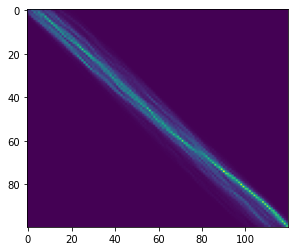

In [16]:
alns = my_affine_sw_func_batch(sim_matrices, lens, -3.0, -1.0, 1.0)
plt.imshow(alns[10]);
plt.show()

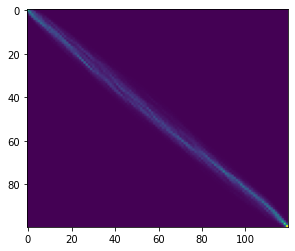

In [17]:
alns = my_nw_func_batch(sim_matrices, lens, -1.0, 1.0)
plt.imshow(alns[10]);
plt.show()

The temperature parameter controls how "smooth" the alignment is: higher values give a more smooth alignment

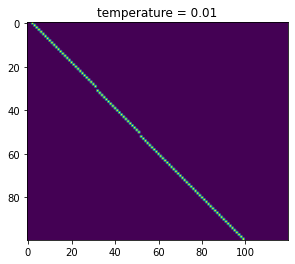

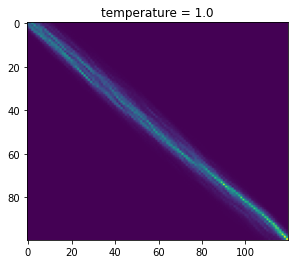

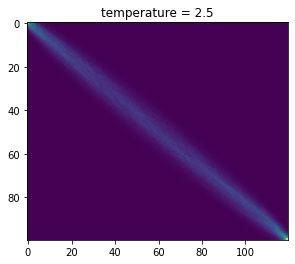

In [18]:
for t in [.01, 1.0, 2.5]:
    alns = my_sw_func_batch(sim_matrices, lens, -1.0, t)
    plt.imshow(alns[10]);
    plt.title(f"temperature = {t}")
    plt.show()

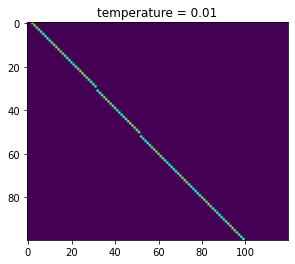

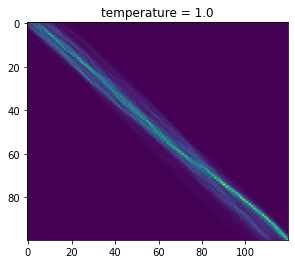

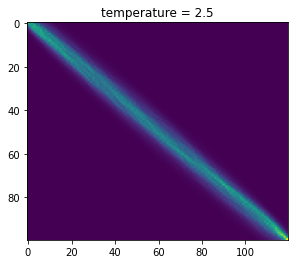

In [19]:
for t in [.01, 1.0, 2.5]:
    alns = my_affine_sw_func_batch(sim_matrices, lens, -3.0, -1.0, t)
    plt.imshow(alns[10]);
    plt.title(f"temperature = {t}")
    plt.show()

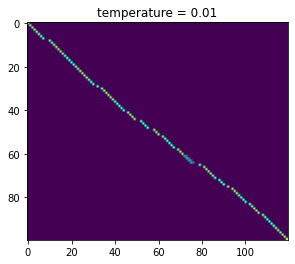

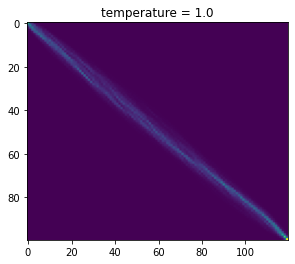

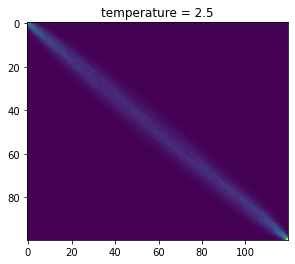

In [20]:
for t in [.01, 1.0, 2.5]:
    alns = my_nw_func_batch(sim_matrices, lens, -1.0, t)
    plt.imshow(alns[10]);
    plt.title(f"temperature = {t}")
    plt.show()